<a href="https://colab.research.google.com/github/fabriciocarraro/kaggle-titanic/blob/main/Kaggle_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [86]:
#Checa o tamanho das bases
print(train.shape, test.shape)

(891, 12) (418, 11)


In [87]:
#Checa quantos valores nulos existem nas bases de treino e teste
missing_values_train = train.isnull().sum()
missing_values_test = test.isnull().sum()
print(missing_values_train)
print()
print(missing_values_test)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [88]:
#Substitui as idades faltantes com a média de idade
train['Age'].fillna(train['Age'].median(), inplace=True)
test['Age'].fillna(test['Age'].median(), inplace=True)

In [89]:
#Função que mostra o gráfico em pilha das features de um conjunto de dados
def bar_chart_stacked(dataset, feature, stacked = True):
    survived = dataset[dataset['Survived']==1][feature].value_counts()
    dead = dataset[dataset['Survived']==0][feature].value_counts()
    df_survived_dead = pd.DataFrame([survived,dead])
    df_survived_dead.index = ['Passengers Survived','Passengers Died']
    ax = df_survived_dead.plot(kind='bar',stacked=stacked, figsize=(5,5))

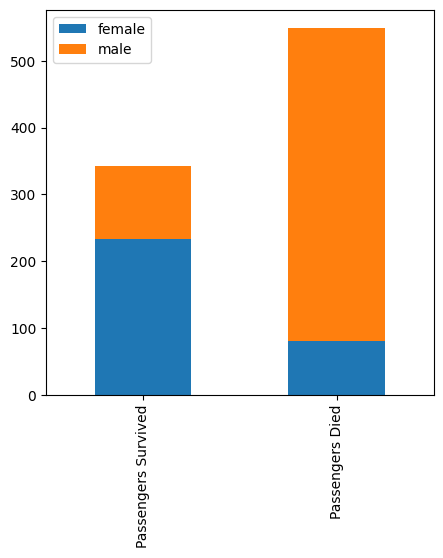

In [90]:
#Analisando se o sexo tem relação com o número de sobreviventes
train['Sex'].value_counts().to_frame()
bar_chart_stacked(train, "Sex")

In [91]:
#Criando uma variável numérica para o sexo
gender_to_int = {'male':0, 'female':1}

train['Sex_binary'] = train['Sex'].map(gender_to_int)
test['Sex_binary'] = test['Sex'].map(gender_to_int)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_binary
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [92]:
#Analisando se a classe (1ª, 2ª, 3ª) tem influência na sobrevivência
train.groupby(['Pclass']).Survived.mean().to_frame()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


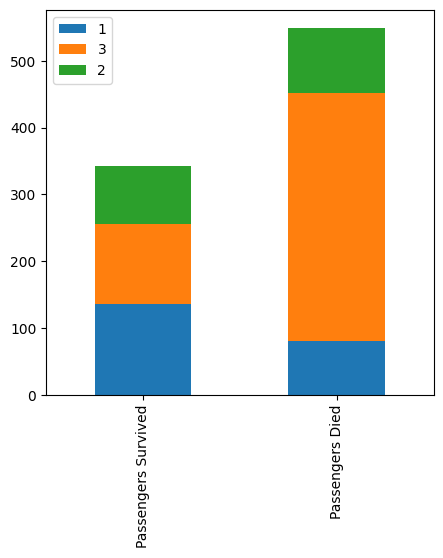

In [93]:
bar_chart_stacked(train, "Pclass")

In [94]:
#Função para comparar duas features lado a lado
def bar_chart_compare(dataset, feature1, feature2=None):
    if feature2 is not None:
        title = f'Survival rate by {feature1} and {feature2}'
    else:
        title = f'Survival rate by {feature1}'
    plt.figure(figsize = [5,5])
    plt.title(title)
    g = sns.barplot(x=feature1, y='Survived', hue=feature2, errorbar=None, data=dataset).set_ylabel('Survival rate')

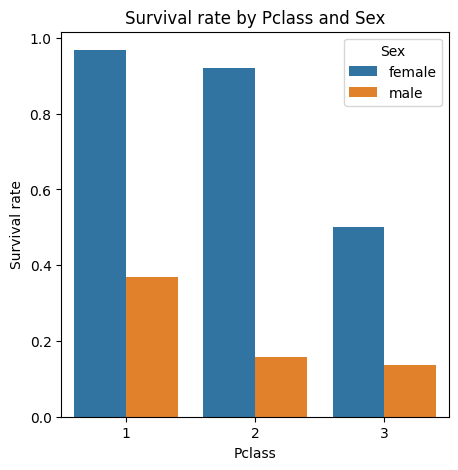

In [95]:
#Analisando a relação entre classe e sexo
bar_chart_compare(train, "Pclass", "Sex")

In [96]:
train.groupby(['Pclass', "Sex"]).Survived.mean().to_frame()

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

In [97]:
#Função para mostrar a distribuição de uma feature em um histograma
def plot_distribution(dataset, feature, title, bins=30, hist=True, fsize=(5,5)):
    plt.figure(figsize=fsize)
    sns.histplot(dataset[feature], color='g', bins=bins, kde=True)
    plt.title(title)
    plt.show()

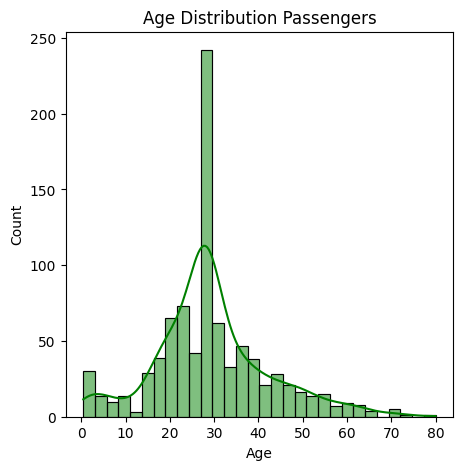

In [98]:
#Analisando as idades
plot_distribution(train, "Age", "Age Distribution Passengers")

In [99]:
#Separando as idades em 5 categorias, criando uma nova coluna com os dados, e uma numérica
age_groups_to_int = {'Baby':0, 'Child':1, 'Teenager':2, 'Adult':3, 'Senior':4}
train['AgeGroup'] = pd.cut(train['Age'], bins=[0, 4, 11, 18, 60, np.inf], labels=age_groups_to_int.keys(), right=False)
test['AgeGroup'] = pd.cut(test['Age'], bins=[0, 6, 12, 18, 60, np.inf], labels=age_groups_to_int.keys(), right=False)
train['AgeGroup_code'] = train['AgeGroup'].map(age_groups_to_int)
test['AgeGroup_code'] = test['AgeGroup'].map(age_groups_to_int)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_binary,AgeGroup,AgeGroup_code
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Adult,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Adult,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Adult,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Adult,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Adult,3


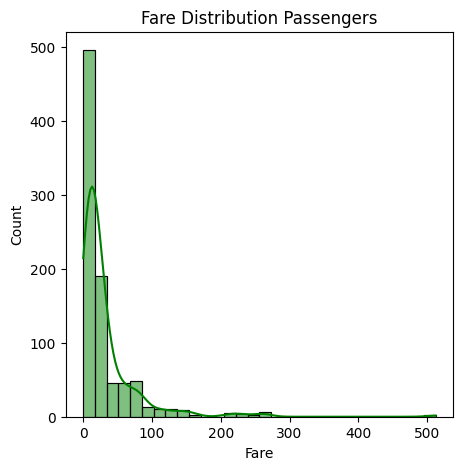

In [100]:
#Analisando o valor das passagens
plot_distribution(train, "Fare", "Fare Distribution Passengers")

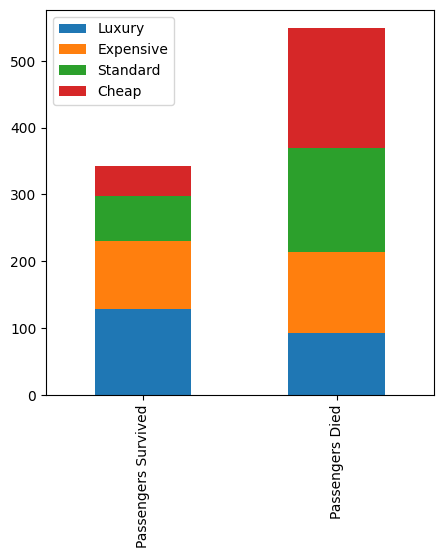

In [105]:
#Separando as passagens em 4 categorias, criando uma nova coluna com os dados
#e analisando a distribuição de sobreviventes em relação a essas categorias
categories = {'Cheap':0, 'Standard':1, 'Expensive':2, 'Luxury':3}
fare_levels_train, fare_bins = pd.qcut(train['Fare'], len(categories), labels = categories.keys(), retbins=True)
fare_levels_test = pd.cut(test['Fare'], bins=fare_bins, labels = categories.keys(), right=False)
train['Fare_level'] = fare_levels_train
test['Fare_level'] = fare_levels_test
bar_chart_stacked(train, "Fare_level")

In [107]:
#Criando uma nova coluna com as categorias de passagem em valor numérico
train['Fare_code'] = train['Fare_level'].map(categories)
test['Fare_code'] = test['Fare_level'].map(categories)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_binary,AgeGroup,AgeGroup_code,Fare_level,Fare_code
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Adult,3,Cheap,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Adult,3,Luxury,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Adult,3,Standard,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Adult,3,Luxury,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Adult,3,Standard,1


In [108]:
#A coluna "Embarked" tinha valores faltantes, então preenchemos com -1
train['Embarked'] = train['Embarked'].fillna(-1)
test['Embarked'] = test['Embarked'].fillna(-1)

In [109]:
#Criando uma nova coluna com o local de embarque em valor numérico
embarked_code = {'S':0, 'C':1, 'Q':2, -1:-1}

train['Embarked_code'] = train['Embarked'].map(embarked_code)
test['Embarked_code'] = test['Embarked'].map(embarked_code)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_binary,AgeGroup,AgeGroup_code,Fare_level,Fare_code,Embarked_code
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Adult,3,Cheap,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Adult,3,Luxury,3,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Adult,3,Standard,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Adult,3,Luxury,3,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Adult,3,Standard,1,0


In [110]:
#Criando uma nova coluna com o título dos passageiros (Mr, Ms, Cpt, etc)
train['Title'] = train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test['Title'] = test['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [111]:
train['Title'].value_counts().to_frame()

,Title
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Mlle,2
Major,2
Col,2
the Countess,1


In [112]:
#Converte os títulos menos frequentes para Mr (masculinos) e Miss (femininos)
train['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
test['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
train['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)
test['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)

In [113]:
train['Title'].value_counts().to_frame()

,Title
Mr,525
Miss,188
Mrs,125
Master,40
Dr,7
Rev,6


In [114]:
#Criando uma nova coluna com o título em valor numérico
title_code = {'Mr':0, 'Miss':1, 'Mrs':2, 'Master':3, 'Dr':4, 'Rev':5}

train['Title_code'] = train['Title'].map(title_code)
test['Title_code'] = test['Title'].map(title_code)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_binary,AgeGroup,AgeGroup_code,Fare_level,Fare_code,Embarked_code,Title,Title_code
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Adult,3,Cheap,0,0,Mr,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Adult,3,Luxury,3,1,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Adult,3,Standard,1,0,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Adult,3,Luxury,3,0,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Adult,3,Standard,1,0,Mr,0


In [116]:
#Cria uma coluna para o tamanho da família, somando a pessoa,
#o número de irmãos/esposos e o número de pais/filhos viajando junto
train['Fam_size'] = train['SibSp'] + train['Parch'] + 1
test['Fam_size'] = test['SibSp'] + test['Parch'] + 1
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Sex_binary,AgeGroup,AgeGroup_code,Fare_level,Fare_code,Embarked_code,Title,Title_code,Fam_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,0,Adult,3,Cheap,0,0,Mr,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,1,Adult,3,Luxury,3,1,Mrs,2,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,1,Adult,3,Standard,1,0,Miss,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,1,Adult,3,Luxury,3,0,Mrs,2,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,0,Adult,3,Standard,1,0,Mr,0,1


In [117]:
#Distribuição do tamanho das familias viajando junto
train["Fam_size"].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: Fam_size, dtype: int64

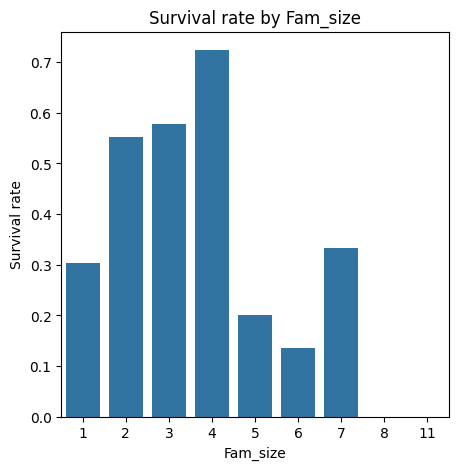

In [118]:
#Relação do tamanho da família viajando junto com a sobrevivência
bar_chart_compare(train, "Fam_size")

In [119]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Sex_binary',
       'AgeGroup', 'AgeGroup_code', 'Fare_level', 'Fare_code', 'Embarked_code',
       'Title', 'Title_code', 'Fam_size'],
      dtype='object')

In [120]:
#Seleção das features e teste de nulo
features = ['Pclass', 'Sex_binary', 'AgeGroup_code', 'Fare_code', 'Embarked_code', 'Title_code', 'Fam_size']
temp = train[features]
temp.isnull().sum()

Pclass           0
Sex_binary       0
AgeGroup_code    0
Fare_code        0
Embarked_code    0
Title_code       0
Fam_size         0
dtype: int64

In [121]:
#Criação dos DataFrames com as features selecionadas
X = train[features]
y = train['Survived']
X.head()

,Pclass,Sex_binary,AgeGroup_code,Fare_code,Embarked_code,Title_code,Fam_size
0,3,0,3,0,0,0,2
1,1,1,3,3,1,2,2
2,3,1,3,1,0,1,1
3,1,1,3,3,0,2,2
4,3,0,3,1,0,0,1


In [127]:
# Configuração do RepeatedKFold
kf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=10)

# Definição do modelo de Random Forest
modelo = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=0)
modelo.fit(X,y)

# Executando a validação cruzada
scores = cross_val_score(modelo, X, y, cv=kf, scoring='accuracy')

print(f"Acurácia de cada fold: {scores}")
print(f"Acurácia média: {np.mean(scores)}")

Acurácia de cada fold: [0.84977578 0.80449438 0.83408072 0.8247191  0.81390135 0.82247191
 0.82735426 0.82696629 0.82959641 0.83595506 0.8206278  0.82921348
 0.84304933 0.81123596 0.83183857 0.83595506 0.83632287 0.80898876
 0.83183857 0.83146067]
Acurácia média: 0.8274923162190759


In [128]:
X_test = test[features]
predictions = modelo.predict(X_test)
predictions

/usr/local/lib/python3.10/dist-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)


array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [130]:
output = pd.DataFrame({'PassengerId':test.PassengerId, 'Survived':predictions})
output.to_csv('Titanic_submission2.csv', index=False)